# Orbital Mechanics and Control
## Import Packages

In [1]:
import orbit
from satellite import Satellite
from dynamics import equation_of_motion
from plots import *

import numpy as np
from scipy.integrate import ode, DOP853
from math import pi

## Input variables
Initialize Orbit using one of the following methods:
- Classical Elements
- State Vector

If necessary, implement the conversion to State Vector for the following:
- Delaunay Elements
- Equinoctial Elements

These functionalities should be added from the Orbit abstract class in orbit.py

In [2]:
# Curtis - Example 4.3
a = 8788
e = 0.1712
i = 153.2
w = 20.07
RA = 255.3
TA = 28.45

orbit0 = orbit.OrbitElements(a,e,i,w,RA,TA)
orbit1 = orbit.OrbitElements(a+50,e,i,w,RA,TA)

R, mu = orbit0.get_central_body()       # Get central body according to orbit
orbit0.activate_perturbation(["Drag","J2"])  # Select perturbations
orbit1.activate_perturbation(["Drag","J2"])  # Select perturbations

sat0 = Satellite(orbit0,mass=100,cd=2.2,area=pi*0.5**2,name="Leader")
sat1 = Satellite(orbit1,mass=100,cd=2.2,area=pi*0.5**2)

satellites = [sat0, sat1]

Initial condition
Position: [-6042.00812834 -3492.07471788  2504.51547769]
Velocity: [-3.45662857  6.61654126  2.53703986]

State Vector: [-6.04200813e+03 -3.49207472e+03  2.50451548e+03 -3.45662857e+00
  6.61654126e+00  2.53703986e+00]

Initial condition
Position: [-6076.38459698 -3511.94314481  2518.76511059]
Velocity: [-3.44683695  6.59779854  2.52985317]

State Vector: [-6.07638460e+03 -3.51194314e+03  2.51876511e+03 -3.44683695e+00
  6.59779854e+00  2.52985317e+00]

Using atmospheric drag (Standard 1976).
Using Earth's Oblateness J2.
Using atmospheric drag (Standard 1976).
Using Earth's Oblateness J2.


## Time setup

In [3]:
# Define simulation time in seconds
t0        = 0
time_end  = 3600*24
time_step = 60
times     = np.arange(0,time_end,step=time_step)

## Linear Control

In [4]:
# Tune control law used
Kp = 0
Ki = 0
Kd = 0

## Simulation

In [5]:
# Simulate orbit
from typing import List
first = ode(equation_of_motion)
second = ode(equation_of_motion)
list_solver = [first, second]

for sat, solver in zip(satellites,list_solver):
    solver.set_integrator('DOP853')
    solver.set_f_params(sat.get_orbit(),sat)
    solver.set_initial_value(sat.get_orbit().get_initial_state(),t0)
    
for time in times:
    for sat,solver in zip(satellites,list_solver):
        solver.integrate(time)

        sat.save_state(solver.y)

/home/msb/Codes/PY/orbital-mechanics/env/lib/python3.10/site-packages/scipy/integrate/_ode.py:431: UserWarning: dop853: step size becomes too small
  self._y, self.t = mth(self.f, self.jac or (lambda: None),


## Plots

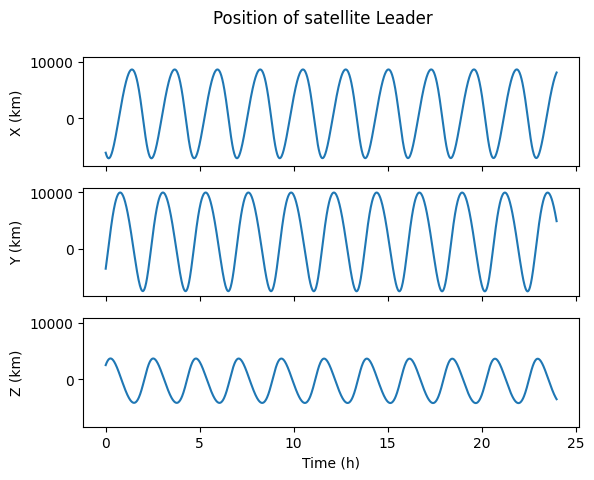

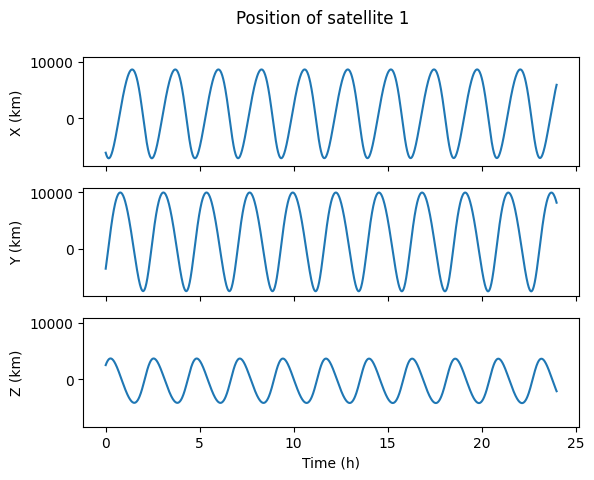

In [6]:
plot_position(satellites,times)

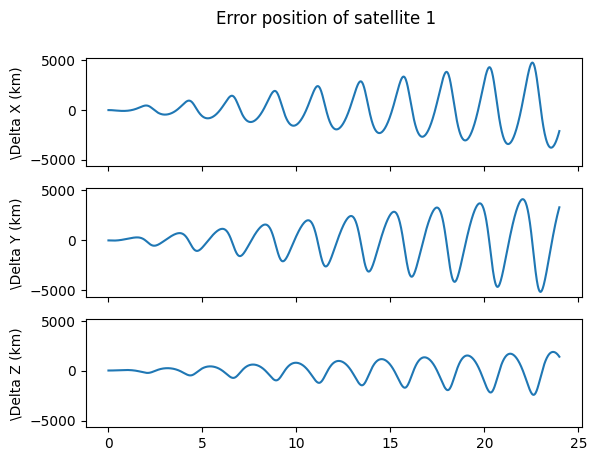

In [7]:
plot_error(satellites,times)

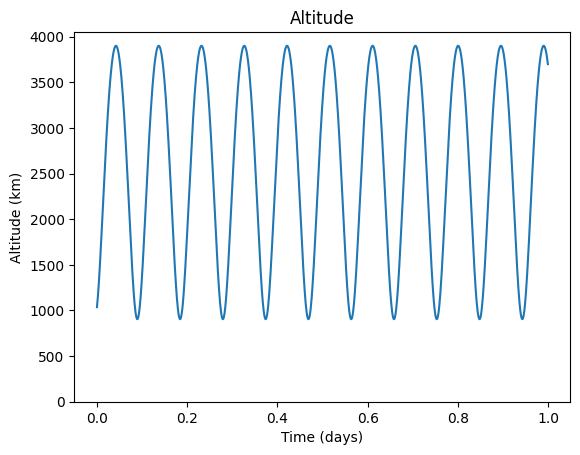

In [8]:
plot_altitude(satellites[0],times,R)

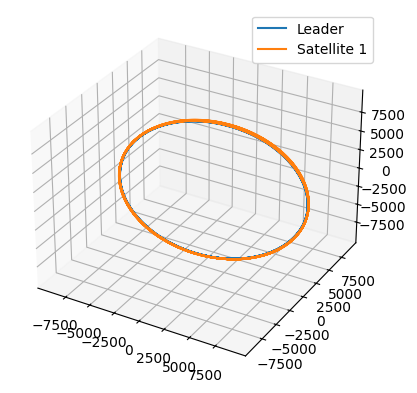

In [9]:
plot3d(satellites,times)